In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import scipy.integrate
import scipy.stats
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore',category=np.ComplexWarning)

In [111]:
def heikin_ashi(data):
    df=data.copy() #can modify copy without affecting original data

    df.reset_index(inplace=True) #if not specified, reset_index() would make new dataframe on top of df

    #HA close
    df['HA close']=(df['Open']+df['Close']+df['High']+df['Low'])/4

    #initialize HA open
    df['HA open']=float(0)
    df['HA open']=df['Open'][0]

    #HA open
    for n in range(1,len(df)):
        df.at[n,'HA open']=(df['HA open'][n-1]+df['HA close'][n-1])/2

    #HA high/low
    temp=pd.concat([df['HA open'],df['HA close'],df['Low'],df['High']],axis=1)
    df['HA high']=temp.apply(max,axis=1)
    df['HA low']=temp.apply(min,axis=1)

    del df['Adj Close']
    del df['Volume']

    return df

In [112]:
def signal_generation(df,method,stls):
    data=method(df)
    data['signals']=0
    data['cumsum']=0

    for n in range(1,len(data)):

        #long triggered condition:
        # 1. candle is filled
        # 2. no upper shadow
        # 3. candle getting longer
        # 4. the previous candle is also filled
        #we want to buy in the stop downtrend, hoping the trend will reverse soon, and then sell in uptrend
        #trading 101: buy low, sell high

        if (data['HA open'][n]>data['HA close'][n] and data['HA open'][n]==data['HA high'][n] and
            np.abs(data['HA open'][n]-data['HA close'][n])>np.abs(data['HA open'][n-1]-data['HA close'][n-1]) and
            data['HA open'][n-1]>data['HA close'][n-1]):
            
            data.at[n,'signals']=1
            data['cumsum']=data['signals'].cumsum()
            if data['cumsum'][n]>stls:
                data.at[n,'signals']=0

        #short conditions:
        # 1. candle is empty
        # 2. no lower shadow
        # 3. previous candle is also green
        elif (data['HA open'][n]<data['HA close'][n] and data['HA open'][n]==data['HA low'][n] and
              data['HA open'][n-1]<data['HA close'][n-1]):
            
            data.at[n,'signals']=-1
            data['cumsum']=data['signals'].cumsum()
            if data['cumsum'][n]>0:
                data.at[n,'signals']=-1*(data['cumsum'][n-1])
            if data['cumsum'][n]<0:
                data.at[n,'signals']=0

    return data

In [129]:
def candlestick(df,ax=None,titlename='',highcol='High',lowcol='Low',
                opencol='Open',closecol='Close',xcol='Date',
                colorup='r',colordown='g',**kwargs):
    #bar width
    dif=[(-3+i)/10 for i in range(7)]

    if not ax:
        ax=plt.figure(figsize(10,5)).add_subplot(111)

    #construct bars one by one
    for i in range(len(df)):

            #width is 0.6 by default
            #so 7 data points required for each bar
            x=[i+j for j in dif]
            y1=[df[opencol].iloc[i]]*7
            y2=[df[closecol].iloc[i]]*7

            barcolor=colorup if y1[0]>y2[0] else colordown

            #no high line if open/close is high
            if df[highcol].iloc[i]!= max(df[opencol].iloc[i],df[closecol].iloc[i]):

            #use generic plot to viz high and low
            #use 1.001 as a scaling factor
            #to prevent high line from crossing into the bar
                plt.plot([i,i],
                 [df[highcol].iloc[i],
                  max(df[opencol].iloc[i],
                      df[closecol].iloc[i])*1.001],c='k',**kwargs) #color is black

            if df[lowcol].iloc[i]!= min(df[opencol].iloc[i],df[closecol].iloc[i]):

            #use generic plot to viz high and low
            #use 1.001 as a scaling factor
            #to prevent low line from crossing into the bar
                plt.plot([i,i],
                 [df[lowcol].iloc[i],
                  max(df[opencol].iloc[i],
                      df[closecol].iloc[i])*0.999],c='k',**kwargs) #color is black

            #treat the bar as fill between
                plt.fill_between(x,y1,y2,
                    edgecolor='k',
                    facecolor=barcolor,**kwargs)

    #only show 5 ticks
    plt.xticks(range(0,len(df),len(df)//5),df[xcol][0::len(df)//5].dt.date)
    plt.title(titlename)

In [130]:
def plot(df,ticker):

    df.set_index(df['Date'],inplace=True)

    #first plot is HA candlestick
    #use candlestick function and set HA O,C,H,L
    ax1=plt.subplot2grid((200,1), (0,0), rowspan=120,ylabel='HA price')
    candlestick(df,ax1,titlename='',highcol='HA high',lowcol='HA low',
               opencol='HA open',closecol='HA close',xcol='Date',
               colorup='r',colordown='g')

    #create a subplot within a grid of 200 rows and 1 column
    #the subplot starts at pos (0,0) in the grid and spans 120 rows vertically
    #the y-axis of the subplot will be labeled as 'HA price'

    plt.grid(True)
    plt.xticks([])
    plt.title('Heikin-Ashi')

    #the second plot is the actual price with long/short positions as up/down arrows
    ax2=plt.subplot2grid((200,1), (120,0), rowspan=80,ylabel='price',xlabel='')
    df['Close'].plot(ax=ax2,label=ticker)

    #long/short positions are attached to the real close price of the stock
    #set line width to 0
    ax2.plot(df.loc[df['signals']==1].index,df['Close'][df['signals']==1],marker='^',lw=0,c='g',label='long')
    ax2.plot(df.loc[df['signals']<0].index,df['Close'][df['signals']<0],marker='v',lw=0,c='r',label='short')

    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

In [131]:
def portfolio(data,capital0=10000,positions=100):

    #cumsum col is created to check the holding of the position
    data['cumsum']=data['signals'].cumsum()

    portfolio=pd.DataFrame()
    portfolio['holdings']=data['cumsum']*data['Close']*positions
    portfolio['cash']=capital0-(data['signals']*data['Close']*positions).cumsum()
    portfolio['total asset']=portfolio['holdings']+portfolio['cash']
    portfolio['return']=portfolio['total asset'].pct_change()
    portfolio['signals']=data['signals']
    portfolio['date']=data['Date']
    portfolio.set_index('date',inplace=True)

    return portfolio

In [132]:
#plotting the asset value change of the portfolio

def profit(portfolio):

    fig=plt.figure()
    bx=fig.add_subplot(111)

    portfolio['total asset'].plot(label='Total Asset')

    #mark long/short positions
    bx.plot(portfolio['signals'].loc[portfolio['signals']==1].index,portfolio['total asset'][portfolio['signals']==1],
           lw=0,marker='^',c='g',label='long')
    bx.plot(portfolio['signals'].loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],
           lw=0,marker='v',c='r',label='short')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.title('Total Asset')
    plt.show()

In [133]:
#omega ratio is a variation of sharpe ratio
#the risk free return is replaced by a given threshold
#Sharpe ratio is the excess return (expected return - risk-free return)/(SD of investment return) and measures. It tells you how much return you are getting for the amount of risk you are taking.
#Omega ratio is a ratio of integrals of probability distributions of returns below a certain threshold and focuses on the likelihood of experiencing losses below a certain threshold. It's a measure 
#                                                                                                                                                             of the ability to handle downside risk.
#we use the t-distribution because normal distribution does not best address tail risk
#empirical distribution is too complex to implement here

def omega(risk_free,degree_of_freedom,maximum,minimum):
    y=scipy.integrate.quad(lambda g:1-scipy.stats.t.cdf(g,degree_of_freedom),risk_free,maximum)
    x=scipy.integrate.quad(lambda g:scipy.stats.t.cdf(g,degree_of_freedom),minimum,risk_free)
    z=(y[0])/(x[0])
    return z

def sortino(risk_free,degree_of_freedom,growth_rate,minimum):
    v=np.sqrt(np.abs(scipy.integrate.quad(lambda g:((risk_free-g)**2)*scipy.stats.t.pdf(g,degree_of_freedom),risk_free,minimum)))
    s=(growth_rate-risk_free)/v[0]
    return s

In [134]:
#the maximum drawdown 
#for every day, we take the current asset value marked to market to compare with the previous highest asset value to get daily drawdown
#implement a temporary variable to store min negative value, called maximum drawdown
#for each daily drawdown that is smaller than the temporary value, we update the temp until traversal is finished

def mdd(series):
    minimum=0
    for i in range(1,len(series)):
        if minimum>(series[i]/max(series[:i])-1):
            minimum=(series[i]/max(series[:i])-1)
    return minimum

In [135]:
#stats calculation

def stats(portfolio,trading_signals,stdate,eddate,capital0=10000):
    stats=pd.DataFrame([0])

    #get min and max of return
    maximum=np.max(portfolio['return'])
    minimum=np.min(portfolio['return'])

    #growth_rate denotes the avg growth rate of portfolio
    #geometric avg
    growth_rate=(float(portfolio['total asset'].iloc[-1]/capital0))**(1/len(trading_signals))-1

    #calculate SD
    std=float(np.sqrt((((portfolio['return']-growth_rate)**2).sum())/len(trading_signals)))

    #use S&P500 as benchmark
    benchmark=yf.download('^GSPC',start=stdate,end=eddate)

    #return of benchmark
    return_of_benchmark=float(benchmark['Close'].iloc[-1]/benchmark['Open'].iloc[0]-1)
    rate_of_benchmark=(return_of_benchmark+1)**(1/len(trading_signals))-1

    del benchmark

    #backtesting stats
    #CAGR stands for cumulated average growth rate
    stats['CAGR']=stats['portfolio return']=float(0)
    stats['CAGR'][0]=growth_rate
    stats['portfolio return'][0]=portfolio['total asset'].iloc[-1]/capital0-1
    stats['benchmark return']=return_of_benchmark
    stats['sharpe ratio']=(growth_rate-rate_of_benchmark)/std
    stats['maximum drawdown']=mdd(portfolio['total asset'])

    #calmar ratio is related to Sharpe
    #the SD is replaced by maximum drawdown
    #it is a measure of return after worst scenario adjustment
    stats['calmar ratio']=growth_rate/stats['maximum drawdown']
    stats['omega ratio']=omega(rate_of_benchmark,len(trading_signals),maximum,minimum)
    stats['sortino ratio']=sortino(rate_of_benchmark,len(trading_signals),growth_rate,minimum)

    #used stop loss limit to limit the longs
    #when clearing positions, we clear all positions at once
    #so every long is always one, and short cannot be larger than the stop loss limit
    stats['numbers of longs']=trading_signals['signals'].loc[trading_signals['signals']==1].count()
    stats['numbers of shorts']=trading_signals['signals'].loc[trading_signals['signals']<0].count()
    stats['numbers of trades']=stats['numbers of shorts']+stats['numbers of longs']

    stats['total length of trades']=trading_signals['signals'].loc[trading_signals['cumsum']!=0].count()
    stats['average length of trades']=stats['total length of trades']/stats['numbers of trades']
    stats['profit per trade']=float(0)
    stats['profit per trade'].iloc[0]=(portfolio['total asset'].iloc[-1]-capital0)/stats['numbers of trades']

    del stats[0]
    print(stats)

[*********************100%%**********************]  1 of 1 completed


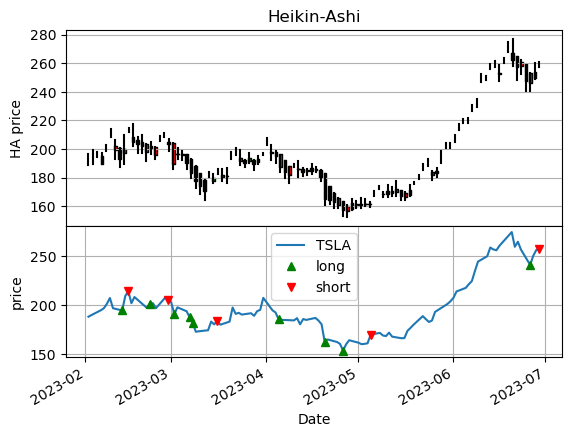

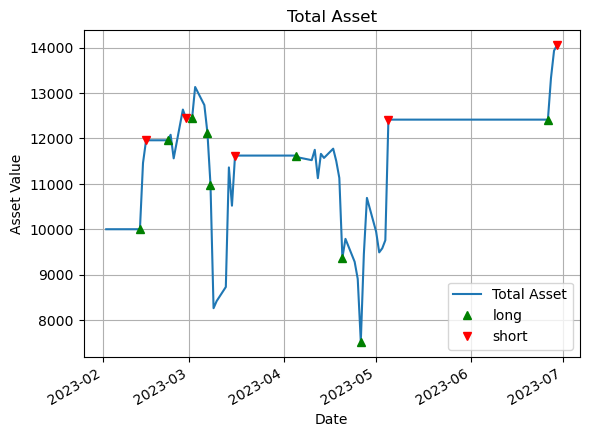

[*********************100%%**********************]  1 of 1 completed

       CAGR  portfolio return  benchmark return  sharpe ratio  \
0  0.003314             0.406          0.080188      0.038685   

   maximum drawdown  calmar ratio  omega ratio  sortino ratio  \
0         -0.427288     -0.007755     1.181251       0.057285   

   numbers of longs  numbers of shorts  numbers of trades  \
0                 9                  5                 14   

   total length of trades  average length of trades  profit per trade  
0                      40                  2.857143        290.000044  



/tmp/ipykernel_154/2161630535.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if minimum>(series[i]/max(series[:i])-1):
/tmp/ipykernel_154/2161630535.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum=(series[i]/max(series[:i])-1)


In [136]:
def main():
    stls=3
    ticker='TSLA'
    stdate='2023-02-01'
    eddate='2023-06-30'

    #slicer used for plotting, a three year dataset with 750 points is too much
    slicer=1

    #downloading data
    df=yf.download(ticker,start=stdate,end=eddate)

    trading_signals=signal_generation(df,heikin_ashi,stls)

    viz=trading_signals[slicer:]
    plot(viz,ticker)

    portfolio_details=portfolio(viz)
    profit(portfolio_details)

    stats(portfolio_details,trading_signals,stdate,eddate)


if __name__ == '__main__':
    main()